In [16]:
# using scvi environment:
import scvi
import scanpy as sc
import numpy as np
import pandas as pd
from datetime import datetime
from rvagene.rvagene import RVAgene
from rvagene.utils import open_data
import numpy as np
import torch
import matplotlib
import seaborn as sns
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import TensorDataset
import sys
import os

%matplotlib inline

os.chdir('/dfs3b/swaruplab/smorabit/collab/AMRF/analysis/ATAC/RVAgene/RVAgene')

## Select Model Parameters

In [8]:
# ODC pseudotime DEGs
opt = {
  'dataset' : "ODC_RVAE",
  'hidden_size' : 48,
  'hidden_layer_depth' : 2,
  'latent_length' : 2,
  'batch_size' : 26,
  'learning_rate' : 0.003,
  'n_epochs' : 100,
  'dropout_rate' : 0.2,
  'optimizer' : 'Adam', # options: ADAM, SGD
  'cuda' : True, # options: True, False
  'print_every' : 5, # must be fewer than batch size?
  'clip' : True, # options: True, False
  'max_grad_norm' : 5,
  'loss' : 'MSELoss', # options: SmoothL1Loss, MSELoss
  'palette' : 'deep' # seaborn color palette
}

## Model setup

In [9]:
X_train, _, y_train, _ = open_data('data', ratio_train=1, dataset=opt['dataset'])
feature_names = pd.read_csv('data/{}/feature_names.csv'.format(opt['dataset']), header=None)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base

train_dataset = TensorDataset(torch.from_numpy(X_train))

sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

rvagene_model = RVAgene(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = opt['hidden_size'],
            hidden_layer_depth = opt['hidden_layer_depth'],
            latent_length = opt['latent_length'],
            batch_size = opt['batch_size'],
            learning_rate = opt['learning_rate'],
            n_epochs = opt['n_epochs'],
            dropout_rate = opt['dropout_rate'],
            optimizer = opt['optimizer'],
            cuda = opt['cuda'],
            print_every=opt['print_every'],
            clip=opt['clip'],
            max_grad_norm=opt['max_grad_norm'],
            loss = opt['loss'],
            #log_file = 'testing2.log'
            log_file = 'data/{}/{}.log'.format(opt['dataset'], opt['dataset'])
)


## Train the model

In [10]:
rvagene_model.fit(train_dataset)


Writing training log to given file, set log_file=None to log to STDOUT


In [11]:
# save trained model:
torch.save(rvagene_model.state_dict(), "models/{}_trained_{}_epochs.pt".format(opt['dataset'], opt['n_epochs']))


In [13]:
# re-load trained model:
rvagene_model.load_state_dict(torch.load("models/{}_trained_{}_epochs.pt".format(opt['dataset'], opt['n_epochs'])))
rvagene_model.eval()


RVAgene(n_epochs=100,batch_size=26,cuda=True)

## Plot the loss curve

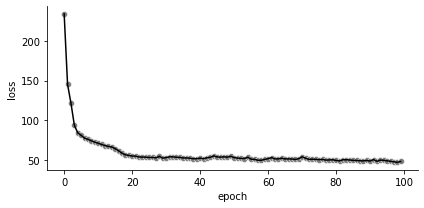

In [17]:

# load log file
file = open('data/{}/{}.log'.format(opt['dataset'], opt['dataset']), 'r')
lines = file.read().splitlines()

loss = []
for line in lines:
  if "Average loss:" in line:
    loss.append(float(line.split(':')[1].replace(' ', '')))

df = pd.DataFrame(loss)
df.columns = ['loss']
df['epoch'] = np.arange(0, df.shape[0])

fig, axes = plt.subplots(figsize=(6,3))
sns.scatterplot(data=df, x='epoch', y='loss', ax=axes, color='gray')
sns.lineplot(data=df, x='epoch', y='loss', ax=axes, color='black')

sns.despine();
plt.tight_layout()
plt.savefig('figures/{}_loss.pdf'.format(opt['dataset']))


## Plot latent space (Z)

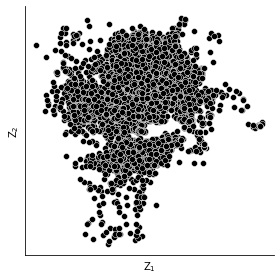

In [22]:
z_run = rvagene_model.transform(train_dataset)  ## latent embeddings of training genes

############### plot 2 dimensional z plot ##################

df = pd.DataFrame()
df['Z1'] = z_run[:,0]
df['Z2'] = z_run[:,1]
df['feature'] = feature_names[0].to_list()[0:df.shape[0]]

label_features = ['SPI1', 'ETS1']
df_labels = df[df['feature'].isin(label_features)]


fig, axes = plt.subplots(figsize=(4,4))
sns.scatterplot(data = df, x="Z1", y='Z2', ax=axes, color='black');
sns.despine();
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False,
    left=False,
    right=False)

# plot text:
# for x,y,label in zip(df_labels['Z1'], df_labels['Z2'], df_labels['feature']):
#   plt.text(x=x, y=y, s=label, color='blue')

params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
axes.set_xlabel("$Z_{1}$")
axes.set_ylabel("$Z_{2}$")
plt.tight_layout()
plt.savefig('figures/{}_Z_embedding.pdf'.format(opt['dataset']))



## Reconstruction

In [23]:

# reconstruct actual data:
smoothed = np.squeeze(rvagene_model.reconstruct(train_dataset))

# df of reconstructed
smoothed_df = pd.DataFrame(smoothed)
smoothed_df.columns = feature_names[0].to_list()[0:smoothed.shape[1]]
smoothed_df['pseudotime_bin'] = np.arange(0, smoothed.shape[0])
smoothed_melted = smoothed_df.melt(id_vars='pseudotime_bin')
smoothed_melted.columns = ['pseudotime_bin', 'feature', 'reconstructed']

# format original data in same way:
feature_df = pd.DataFrame(np.transpose(np.squeeze(X_train)[0:smoothed.shape[1]]))
feature_df.columns = feature_names[0].to_list()[0:smoothed.shape[1]]
feature_df['pseudotime_bin'] = np.arange(0, smoothed.shape[0])
feature_melted = feature_df.melt(id_vars='pseudotime_bin')
feature_melted.columns = ['pseudotime_bin', 'feature', 'original']

# combine table:
smoothed_melted['original'] = feature_melted['original']

# write reconstructed matrix
out_df = smoothed_df.drop('pseudotime_bin', axis=1).transpose()
out_df['Z1'] = df['Z1'].to_list()
out_df['Z2'] = df['Z2'].to_list()

# write output
out_df.to_csv('data/reconstructed/{}_recon.csv'.format(opt['dataset']), header=True)


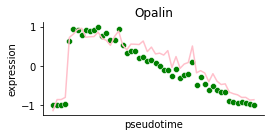

In [32]:
# plot reconstruction for a few genes:

cur_gene = 'Mbp'
cur_gene = 'Pdgfra'
cur_gene = 'Klk6'
cur_gene = 'Opalin'

gene_df = smoothed_melted[smoothed_melted['feature'] == cur_gene]
gene_df.shape

fig, axes = plt.subplots(figsize=(4,2))
sns.scatterplot(data=gene_df, x='pseudotime_bin', y='original', ax=axes, color='green')
sns.lineplot(data=gene_df, x='pseudotime_bin', y='reconstructed', ax=axes, color='pink')

axes.set_title(cur_gene)
axes.set_xlabel("pseudotime")
axes.set_ylabel("expression")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
    )
sns.despine();
plt.tight_layout()
plt.savefig('figures/{}_{}_reconstructed.pdf'.format(opt['dataset'], cur_gene))


## Use trained model to predict on another dataset (aka gl-cCRE datasets)

In [ ]:

# load other data:
other_data_name = 'MG_enhancers'
other_data_name = 'ASC_enhancers'
other_data_name = 'ODC_enhancers'


X_other, _, y_other, _ = open_data('data', ratio_train=1, dataset=other_data_name)
other_feature_names = pd.read_csv('data/{}/feature_names.csv'.format(other_data_name), header=None)

other_dataset = TensorDataset(torch.from_numpy(X_other))

# reconstruct actual data:
z_other = rvagene_model.transform(other_dataset)  ## latent embeddings of training genes
smoothed_other = np.squeeze(rvagene_model.reconstruct(other_dataset))

# Z df
df = pd.DataFrame()
df['Z1'] = z_other[:,0]
df['Z2'] = z_other[:,1]
df['feature'] = other_feature_names[0].to_list()[0:df.shape[0]]


# df of reconstructed
smoothed_df = pd.DataFrame(smoothed_other)
smoothed_df.columns = other_feature_names[0].to_list()[0:smoothed_df.shape[1]]
smoothed_df['pseudotime_bin'] = np.arange(0, smoothed_other.shape[0])
smoothed_melted = smoothed_df.melt(id_vars='pseudotime_bin')
smoothed_melted.columns = ['pseudotime_bin', 'feature', 'reconstructed']

# format original data in same way:
feature_df = pd.DataFrame(np.transpose(np.squeeze(X_other)[0:smoothed_other.shape[1]]))
feature_df.columns = other_feature_names[0].to_list()[0:smoothed_other.shape[1]]
feature_df['pseudotime_bin'] = np.arange(0, smoothed_other.shape[0])
feature_melted = feature_df.melt(id_vars='pseudotime_bin')
feature_melted.columns = ['pseudotime_bin', 'feature', 'original']

# combine table:
smoothed_melted['original'] = feature_melted['original']

# write reconstructed matrix
# add k-means cluster ID and Z1 Z2 to this table!!
out_df = smoothed_df.drop('pseudotime_bin', axis=1).transpose()
out_df['Z1'] = df['Z1'].to_list()
out_df['Z2'] = df['Z2'].to_list()
# out_df['cluster'] = df['cluster'].to_list()


out_df.to_csv('data/reconstructed/{}_recon.csv'.format(other_data_name), header=True)

